In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Rectangle
from torchvision import datasets, transforms
# These packages are required by the visualization utils
import seaborn as sns  
from sklearn.manifold import TSNE

import vae_utils


# Variational Autoencoder for MNIST and FireEvac




## Load the dataset

In [2]:
mnist = False

def npy_loader(path):
    return torch.from_numpy(np.load(path))

device = 'cpu'
# device = 'cpu'  # uncomment this line to run the model on the CPU
batch_size = 128
if mnist:
    dataset = datasets.MNIST 
    if device == 'cuda':
        train_loader = torch.utils.data.DataLoader(
            dataset('data', train=True, download=True, transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
        )
        test_loader = torch.utils.data.DataLoader(
            dataset('data', train=False, download=True, transform=transforms.ToTensor()),
            batch_size=1000, shuffle=True, num_workers=1, pin_memory=True
        )
    elif device == 'cpu':
        train_loader = torch.utils.data.DataLoader(
            dataset('data', train=True, download=True, transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True,
        )
        test_loader = torch.utils.data.DataLoader(
            dataset('data', train=False, download=True, transform=transforms.ToTensor()),
            batch_size=1000, shuffle=True,
        )
else:
    tr = np.load("/Users/unstblecrsr/Desktop/Praktikum/exercise_4/tra/FireEvac_train_set.npy")
    tes = np.load("/Users/unstblecrsr/Desktop/Praktikum/exercise_4/tes/FireEvac_test_set.npy")
    tensor_tr = torch.from_numpy(tr) #/ 200 # transform to torch tensor
    tensor_tes = torch.from_numpy(tes)# / 200
     # create your datset
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(tensor_tr),
        batch_size=batch_size,
        shuffle=True,)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(tensor_tes),
        batch_size=600, 
        shuffle=True,)
    

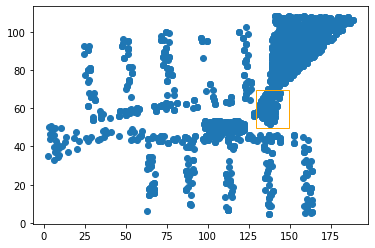

274


In [3]:
__x = []
__y = []
num_people = 0
for i in range(len(train_loader.dataset)):
    pos_x = train_loader.dataset[i][0][0].item()#*200
    pos_y = train_loader.dataset[i][0][1].item()#*200
    
    __x.append(pos_x)
    __y.append(pos_y)
    if 130 < pos_x < 150 and 50 < pos_y < 70:
        num_people += 1
    
    

someX, someY = 130, 50
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .5, someY - .5), 20, 20, color="orange", fill=False))
plt.scatter(__x,__y)

plt.savefig("train_data_viz.png")
plt.show()
print(num_people)

In [4]:
class VAE(nn.Module):
    def __init__(self, obs_dim, latent_dim, hidden_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        # Trainable layers of the encoder
        self.linear1 = nn.Linear(obs_dim, hidden_dim)
        self.linear21 = nn.Linear(hidden_dim, latent_dim)
        self.linear22 = nn.Linear(hidden_dim, latent_dim)
        # Trainable layers of the decoder
        self.linear3 = nn.Linear(latent_dim, hidden_dim)
        self.linear_Extra = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, obs_dim)
    
    def encoder(self, x):

        l1 = F.relu(self.linear1(x))
        mu = self.linear21(l1)
        logsigma = self.linear22(l1)
        
        return mu, logsigma
    
    def sample_with_reparam(self, mu, logsigma):

        sigma = torch.diag(torch.exp(logsigma) ** 2)
        normal_distt = torch.empty(sigma.shape).normal_(0,1)
        
        return normal_distt * sigma + mu
        
    
    def decoder(self, z):

        l1 = F.relu(self.linear3(z))
        #l_extra = F.relu(self.linear_Extra(l1))
        theta = F.relu(self.linear4(l1))
        return theta

    
    def kl_divergence(self, mu, logsigma):

        sigma_squared = torch.exp(logsigma) ** 2
        return 0.5*torch.sum(mu**2 - 1 - logsigma*2 + sigma_squared, dim=1)

    
    def elbo(self, x):

        mu, logsigma = self.encoder(x)
        z_prime = self.sample_with_reparam(mu, logsigma)
        theta = self.decoder(z_prime)
        c_e = (x - theta) ** 2
        cross_entropy = torch.sum(c_e, dim=1)
        return - cross_entropy - self.kl_divergence(mu, logsigma)

        
    def sample(self, num_samples):
  
        normal_distt = torch.empty(num_samples, latent_dim).normal_(0,1)
        x = self.decoder(normal_distt)
        
        return x

In [13]:
obs_dim = 2  # FireEvac data has format: [x,y]
latent_dim = 2  # Size of the latent variable z
hidden_dim = 50  # Size of the hidden layer in the encoder / decoder


vae = VAE(obs_dim, latent_dim, hidden_dim).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
losses = []

In [34]:
max_epochs = 50
display_step = 100
stopper_counter = 0
for epoch in range(max_epochs):
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):
        #print(batch[0].float())
        #print(batch[0].shape)
        x = batch[0].float() #print(batch)#x = batch[0][0]
        
        #x = x.view(x.shape[0], obs_dim).to(device)  # we flatten the image into 1D array
        opt.zero_grad()
        # We want to maximize the ELBO, so we minimize the negative ELBO
        loss = -vae.elbo(x).mean(-1)
        loss.backward()
        opt.step()
        #losses.append(loss.item())
        if ix % display_step == 0:
            print(f'  loss = {loss.item():.2f}')
    if loss.item() < 20.0:
        stopper_counter += 1
    else: 
        stopper_counter = 0
    losses.append(loss.item())
    if stopper_counter > 4:
        break

Epoch 0
  loss = 24.02
Epoch 1
  loss = 31.01
Epoch 2
  loss = 47.10
Epoch 3
  loss = 26.93
Epoch 4
  loss = 23.17
Epoch 5
  loss = 27.66
Epoch 6
  loss = 20.45
Epoch 7
  loss = 20.06
Epoch 8
  loss = 28.25
Epoch 9
  loss = 53.88
Epoch 10
  loss = 31.17
Epoch 11
  loss = 27.27
Epoch 12
  loss = 19.84
Epoch 13
  loss = 30.31
Epoch 14
  loss = 23.70
Epoch 15
  loss = 177.30
Epoch 16
  loss = 22.93
Epoch 17
  loss = 22.57
Epoch 18
  loss = 30.81
Epoch 19
  loss = 24.68
Epoch 20
  loss = 18.45
Epoch 21
  loss = 25.50
Epoch 22
  loss = 20.69
Epoch 23
  loss = 26.98
Epoch 24
  loss = 24.86
Epoch 25
  loss = 20.84
Epoch 26
  loss = 33.28
Epoch 27
  loss = 26.33
Epoch 28
  loss = 19.27
Epoch 29
  loss = 37.45
Epoch 30
  loss = 37.12
Epoch 31
  loss = 28.89
Epoch 32
  loss = 27.47
Epoch 33
  loss = 39.25
Epoch 34
  loss = 61.59
Epoch 35
  loss = 24.27
Epoch 36
  loss = 23.21
Epoch 37
  loss = 22.15
Epoch 38
  loss = 30.51
Epoch 39
  loss = 45.20
Epoch 40
  loss = 19.62
Epoch 41
  loss = 22.44
E

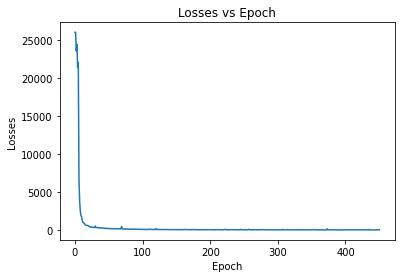

In [35]:
plt.plot(losses)
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.title('Losses vs Epoch')
plt.savefig("GAR_loss_ep_" + str(max_epochs)  + "latdim_" + str(latent_dim) + ".png")

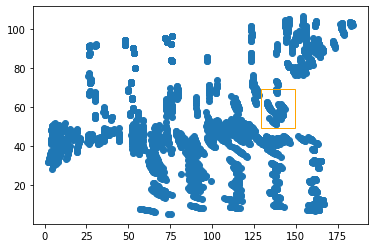

150


In [36]:

# num_rows=2
# num_cols=5
# sns.set_style('white')
# num_total = num_rows * num_cols
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
# for i in range(num_total):
#     ax = axes[i // num_cols, i % num_cols]
#     idx = np.random.randint(len(test_loader.dataset))
#     x = test_loader.dataset[idx][0]
#     y = test_loader.dataset[idx][1]
#     x = x.view(x.shape[0], obs_dim).to(device)
#     mu, logsigma = vae.encoder(x)
#     z_prime = vae.sample_with_reparam(mu, logsigma)
#     theta = vae.decoder(z_prime).view(-1, 28, 28).detach().cpu().numpy()[0]
#     ax.imshow(theta, cmap='gray', vmin=0.0, vmax=1.0)
#     ax.set_title(f'Class: {y}')
# plt.tight_layout()
# plt.savefig("GAR_rec_ep_" + str(max_epochs) + "latdim_" + str(latent_dim) + ".png")
# plt.show()


__x = []
__y = []
num_people = 0
num_ssamples = 5000
primes = []

for i in range(num_ssamples):
    idx = np.random.randint(len(test_loader.dataset))
    x = test_loader.dataset[idx][0].float()
    #print(x)
    mu, logsigma = vae.encoder(x)
    z_prime = vae.sample_with_reparam(mu, logsigma)
    primes.append(z_prime)
    theta = vae.decoder(z_prime)
    #print(theta[0][0].item())
    pos_x = theta[0][0].item()#*200
    pos_y = theta[0][1].item()#*200
    __x.append(pos_x)
    __y.append(pos_y)
    if 130 < pos_x < 150 and 50 < pos_y < 70:
        num_people += 1
    
    

someX, someY = 130, 50
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .5, someY - .5), 20, 20, color="orange", fill=False))
plt.scatter(__x,__y)

plt.savefig("GAR_rec_ep_" + str(max_epochs) + "latdim_" + str(latent_dim) + "num_samp_" + str(num_ssamples) + "inbox_"+ str(num_people) +".png")
plt.show()
print(num_people)

### Visualize samples generated by the model

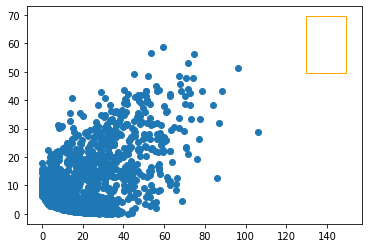

0


In [37]:
# samples = vae.sample(10).view(-1, 28, 28).detach().cpu().numpy()
# sns.set_style('white')
# num_total = num_rows * num_cols
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
# for i in range(num_total):
#     ax = axes[i // num_cols, i % num_cols]
#     ax.imshow(samples[i], cmap='gray', vmin=0.0, vmax=1.0)
#     ax.set_title(f'Sample #{i}')
# plt.tight_layout()
# plt.savefig("GAR_gen_ep_" + str(max_epochs)+ "latdim_" + str(latent_dim) + ".png")
# plt.show()

__x = []
__y = []
num_people = 0
num_ssamples = 1000
normal_distt = torch.empty(num_ssamples, latent_dim).normal_(0,1)
samples = vae.decoder(normal_distt)
for i in samples:
    #print(theta[0][0].item())
    pos_x = i[0].item()#*200
    pos_y = i[1].item()#*200
    __x.append(pos_x)
    __y.append(pos_y)
    if 130 < pos_x < 150 and 50 < pos_y < 70:
        num_people += 1
    
    

someX, someY = 130, 50
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .5, someY - .5), 20, 20, color="orange", fill=False))
plt.scatter(__x,__y)

plt.savefig("GAR_gen_ep_" + str(max_epochs) + "latdim_" + str(latent_dim) + "num_samp_" + str(num_ssamples) + "inbox_"+ str(num_people) +".png")
plt.show()
print(num_people)

While the images here look somewhat similar to the training data and it's possible to discern the shapes of different digits, the sampels are not visually coherent.
You might need to run the above cell several times to obtain images that look decent.

It's possible to obtain images that look a lot better by using more 
powerful encoders & decoders (see `nn.Conv2d` and `nn.ConvTranspose2d`).
However, training such models is slower, unless you have a good GPU.

### Visualize the embeddings produced by the model
Here, we visualize the embeddings learned by the encoder using the following procedure
1. Take a mini-batch `x` (shape `[batch_size, obs_dim]`)
2. Pass `x` through the encoder 
```
mu, logsigma = vae.encoder(x)
```
3. Visualize the mean `mu` for each sample using t-SNE.

ValueError: not enough values to unpack (expected 2, got 1)

As we can see, the encoder learned to assign similar means to the images that belong to the same class. That means, if two samples $x_i$ and $x_j$ belong to the same class, the means $\mu_i$ and $\mu_j$ of their variational distributions $q_i(z_i)$ and $q_j(z_j)$ are nearby, so $z_i$ and $z_j$ will likely be close as well.